### Trade-off Plot: Energy vs Code Quality (Mean Levenshtein)

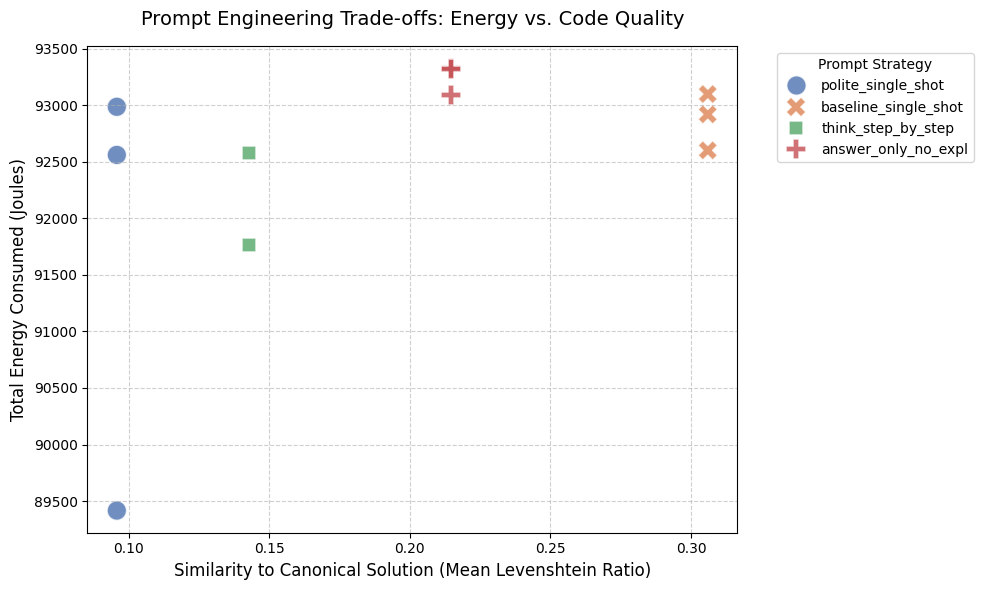

In [12]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

log_file_path = Path("../outputs/energy_runs.jsonl")
data = []

with log_file_path.open("r", encoding="utf-8") as f:
    for line in f:
        run = json.loads(line.strip())
        
        if run.get("energy_j") is not None and run.get("metrics"):
            data.append({
                "Condition": run["condition_id"],
                "Repeat": run["repeat"],
                "Energy (Joules)": run["energy_j"],
                "Quality (Levenshtein Ratio)": run["metrics"].get("mean_levenshtein_ratio", 0),
                "Quality (CodeBLEU)": run["metrics"].get("mean_codebleu", 0)
            })

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    data=df,
    x="Quality (Levenshtein Ratio)", 
    y="Energy (Joules)",
    hue="Condition",
    style="Condition",
    s=200,
    alpha=0.8,
    palette="deep"
)

plt.title("Prompt Engineering Trade-offs: Energy vs. Code Quality", fontsize=14, pad=15)
plt.xlabel("Similarity to Canonical Solution (Mean Levenshtein Ratio)", fontsize=12)
plt.ylabel("Total Energy Consumed (Joules)", fontsize=12)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Prompt Strategy")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

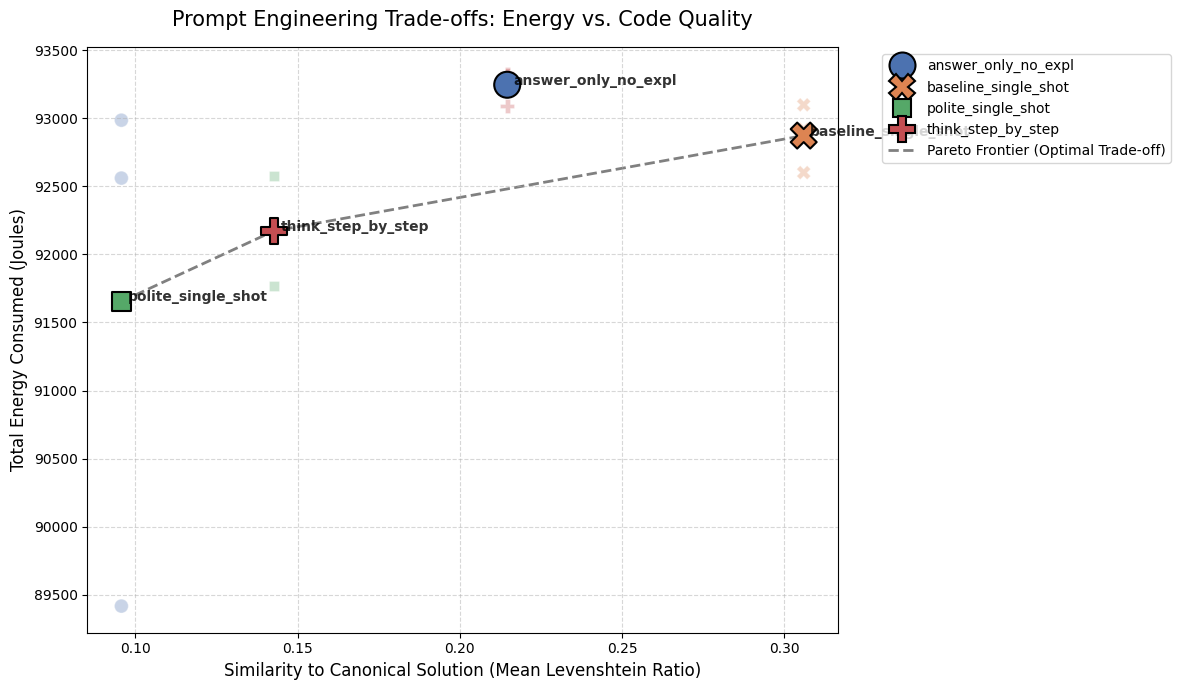

In [13]:
# Calculate the Centroids (mean energy and mean quality for each condition)
centroids = df.groupby('Condition').agg({
    'Quality (Levenshtein Ratio)': 'mean',
    'Energy (Joules)': 'mean'
}).reset_index()

plt.figure(figsize=(12, 7))

# Plot the raw individual runs
sns.scatterplot(
    data=df,
    x="Quality (Levenshtein Ratio)", 
    y="Energy (Joules)",
    hue="Condition",
    style="Condition",
    s=100,      
    alpha=0.3,  # high transparency
    palette="deep",
    legend=False
)

# Plot the centroids
sns.scatterplot(
    data=centroids,
    x="Quality (Levenshtein Ratio)", 
    y="Energy (Joules)",
    hue="Condition",
    style="Condition",
    s=350,      
    edgecolor='black',
    linewidth=1.5,
    palette="deep"
)

for i, row in centroids.iterrows():
    plt.text(
        row['Quality (Levenshtein Ratio)'] + 0.002, # Small horizontal offset
        row['Energy (Joules)'],                     
        row['Condition'],
        fontsize=10,
        weight='bold',
        alpha=0.8
    )

# Calculate and plot the Pareto Frontier
pareto_sorted = centroids.sort_values('Quality (Levenshtein Ratio)', ascending=False)
frontier = []
min_energy = float('inf')

for _, row in pareto_sorted.iterrows():
    if row['Energy (Joules)'] < min_energy:
        frontier.append(row)
        min_energy = row['Energy (Joules)']

# Sort ascending to draw the line correctly from left to right
frontier_df = pd.DataFrame(frontier).sort_values('Quality (Levenshtein Ratio)')

plt.plot(
    frontier_df['Quality (Levenshtein Ratio)'],
    frontier_df['Energy (Joules)'],
    color='grey',
    linestyle='--',
    linewidth=2,
    zorder=0,
    label='Pareto Frontier (Optimal Trade-off)'
)

plt.title("Prompt Engineering Trade-offs: Energy vs. Code Quality", fontsize=15, pad=15)
plt.xlabel("Similarity to Canonical Solution (Mean Levenshtein Ratio)", fontsize=12)
plt.ylabel("Total Energy Consumed (Joules)", fontsize=12)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

### Trade-off Plot: Energy vs Code Quality (Mean CodeBLEU)

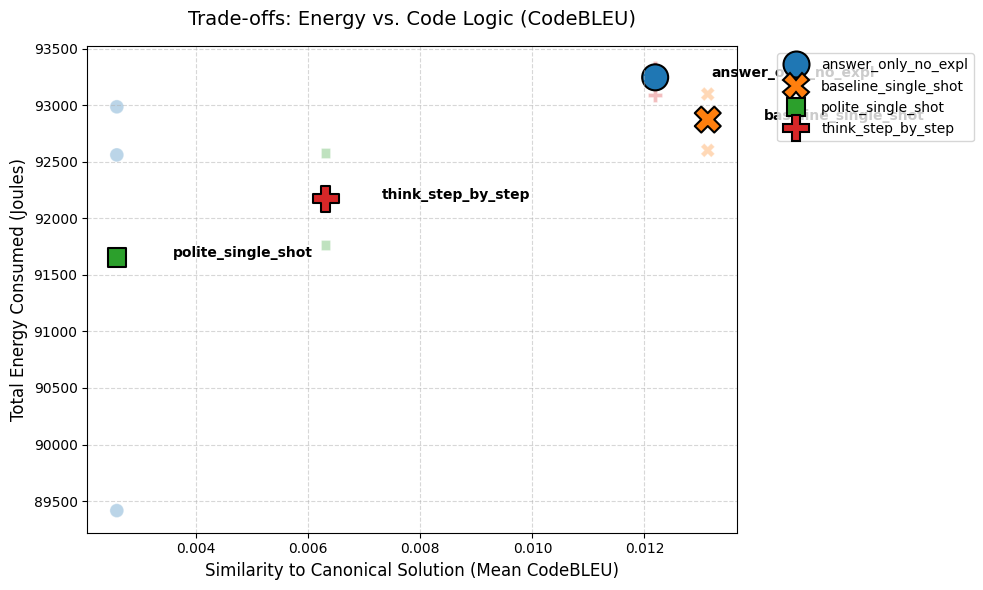

In [14]:
# Calculate centroids for CodeBLEU
centroids_cb = df.groupby('Condition').agg({
    'Quality (CodeBLEU)': 'mean',
    'Energy (Joules)': 'mean'
}).reset_index()

plt.figure(figsize=(10, 6))

# Plot background scatter
sns.scatterplot(data=df, x="Quality (CodeBLEU)", y="Energy (Joules)", 
                hue="Condition", style="Condition", s=100, alpha=0.3, legend=False)

# Plot centroids
sns.scatterplot(data=centroids_cb, x="Quality (CodeBLEU)", y="Energy (Joules)", 
                hue="Condition", style="Condition", s=350, edgecolor='black')

for i, row in centroids_cb.iterrows():
    plt.text(row['Quality (CodeBLEU)'] + 0.001, row['Energy (Joules)'], 
             row['Condition'], fontsize=10, weight='bold')

plt.title("Trade-offs: Energy vs. Code Logic (CodeBLEU)", fontsize=14, pad=15)
plt.xlabel("Similarity to Canonical Solution (Mean CodeBLEU)", fontsize=12)
plt.ylabel("Total Energy Consumed (Joules)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### Relative Change Plot (Centered on Baseline)
Centers baseline_single_shot at (0, 0), and divides the plot into quadrants. If a dot lands in the bottom-right quadrant, it is better and cheaper than doing nothing (baseline). If it lands top-left, it is worse and more expensive.

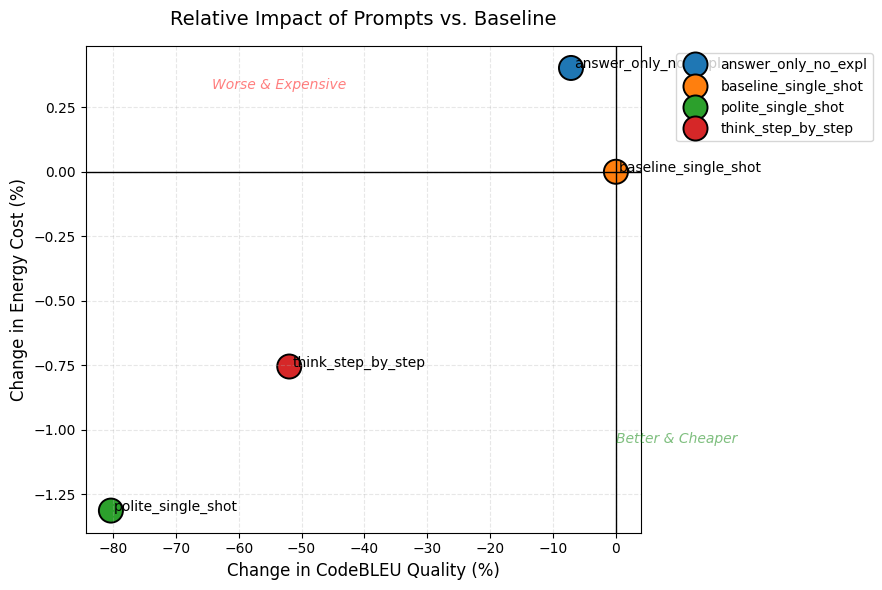

In [15]:
baseline_cb = centroids_cb[centroids_cb['Condition'] == 'baseline_single_shot'].iloc[0]
base_cb_val = baseline_cb['Quality (CodeBLEU)']
base_energy_val = baseline_cb['Energy (Joules)']
deltas = centroids_cb.copy()
deltas['Δ Quality (%)'] = ((deltas['Quality (CodeBLEU)'] - base_cb_val) / base_cb_val) * 100
deltas['Δ Energy (%)'] = ((deltas['Energy (Joules)'] - base_energy_val) / base_energy_val) * 100

plt.figure(figsize=(9, 6))

sns.scatterplot(data=deltas, x="Δ Quality (%)", y="Δ Energy (%)", 
                hue="Condition", s=300, edgecolor='black')

plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)

plt.text(max(deltas['Δ Quality (%)']) * 0.8, min(deltas['Δ Energy (%)']) * 0.8, 'Better & Cheaper', color='green', alpha=0.5, style='italic')
plt.text(min(deltas['Δ Quality (%)']) * 0.8, max(deltas['Δ Energy (%)']) * 0.8, 'Worse & Expensive', color='red', alpha=0.5, style='italic')

for i, row in deltas.iterrows():
    plt.text(row['Δ Quality (%)'] + 0.5, row['Δ Energy (%)'], 
             row['Condition'], fontsize=10)

plt.title("Relative Impact of Prompts vs. Baseline", fontsize=14, pad=15)
plt.xlabel("Change in CodeBLEU Quality (%)", fontsize=12)
plt.ylabel("Change in Energy Cost (%)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### The "Bang for your Buck" Bar Chart

C:\Users\anton\AppData\Local\Temp\ipykernel_12576\753432057.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=centroids_cb, x="Efficiency Ratio", y="Condition", palette="viridis")


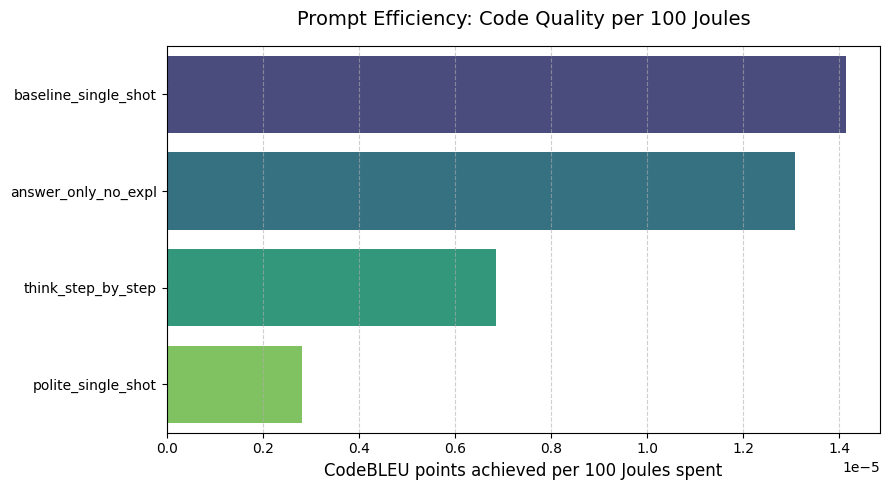

In [16]:
# Calculate Efficiency Ratio
centroids_cb['Efficiency Ratio'] = (centroids_cb['Quality (CodeBLEU)'] / centroids_cb['Energy (Joules)']) * 100

# Sort by most efficient
centroids_cb = centroids_cb.sort_values('Efficiency Ratio', ascending=False)

plt.figure(figsize=(9, 5))
sns.barplot(data=centroids_cb, x="Efficiency Ratio", y="Condition", palette="viridis")

plt.title("Prompt Efficiency: Code Quality per 100 Joules", fontsize=14, pad=15)
plt.xlabel("CodeBLEU points achieved per 100 Joules spent", fontsize=12)
plt.ylabel("")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()